In [1]:
using Plots
using Random
using Statistics
using LinearAlgebra
using BenchmarkTools
using Plots

# equations and structures

In [2]:
function initialize_simulation_hyperparameters(Lx::Float64,Ly::Float64,dt::Float64,dx::Float64,dy::Float64,Nx::Float64,Ny::Float64)
    #=
    all variables are set to be Float64 to more efficiently pass the hyperparameters. Ny and Nx are integers.
    =#
    return Dict("Lx"=>Lx, "Ly"=>Ly, "dt"=>dt, "dx"=>dx, "dy"=>dy, "Nx"=>Nx, "Ny"=>Ny)
end

#intended to be inside dict of cell types
function initialize_type_hyperparameters(tau_u::Float64, D::Float64, eta_s::Float64, eta::Float64, gamma::Float64, alpha::Float64, beta::Float64, beta_s::Float64, V_max::Float64, L::Float64, volLim::Float64)
    return Dict("tau_u" => tau_u, "D" => D, "eta_s" => eta_s, "eta" => eta, "gamma" => gamma, "alpha" => alpha, "beta" => beta, "beta_s" => beta_s, "V_max" => V_max, "L" => L, "volLim" => volLim)
end

function extract_hyperparameter_vars(cell_hyp::Dict{String, Float64})
    tau_u = get(cell_hyp, "tau_u", missing)
    D = get(cell_hyp, "D", missing)
    eta_s = get(cell_hyp, "eta_s", missing)
    eta = get(cell_hyp, "eta", missing)
    gamma = get(cell_hyp, "gamma", missing)
    alpha = get(cell_hyp, "alpha", missing)
    beta = get(cell_hyp, "beta", missing)
    beta_s = get(cell_hyp, "beta_s", missing)
    V_max = get(cell_hyp, "V_max", missing)
    L = get(cell_hyp, "L", missing)
    
    return tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L
end

mutable struct PhaseField
    field::Matrix{Float64}
    field_laplacian::Matrix{Float64}
    h_field_laplacian::Matrix{Float64}
    volume::Float64
    type::String
    type_hyp::Dict
    com_x::Int64
    com_y::Int64
    com_x_arb::Float64
    com_y_arb::Float64
end

function PhaseField(hpars::Dict{String, Float64}, type::String, type_hyp::Dict, field::Matrix{Float64})
    #=
    types_hpars is dict of cell hyperparameter dicts
    type is type name
    hpars are simulation hyperparameters
    field is a field matrix
    =#
    Nx, Ny = Int64(hpars["Nx"]), Int64(hpars["Ny"])
    field_laplacian = zeros(Nx, Ny)
    laplacian!(hpars, field_laplacian, field)
    h_field_laplacian = zeros(Nx, Ny)
    laplacian!(hpars, h_field_laplacian, h.(field))
    return PhaseField(field, field_laplacian, h_field_laplacian, 0., type, type_hyp, 0, 0, 0., 0.)
end

function PhaseField(hpars::Dict{String, Float64}, type::String, type_hyp::Dict)
    #=
    types_hpars is dict of cell hyperparameter dicts
    type is type name
    hpars are simulation hyperparameters
    field is assumed to be zero everywhere
    =#
    Nx, Ny = Int64(hpars["Nx"]), Int64(hpars["Ny"])
    field = zeros(Nx, Ny)
    field_laplacian = zeros(Nx, Ny)
    h_field_laplacian = zeros(Nx, Ny)
    return PhaseField(field, field_laplacian, h_field_laplacian, 0., type, type_hyp, 0, 0, 0., 0.)
end

h(f) = f * f * (3 - 2 *f)
kdelta(i,j) = i == j ? 1 : 0
volume(f::Matrix{Float64}, dx::Float64, dy::Float64) = sum(f)*dx*dy

#optimized laplacian
function laplacian!(hpars::Dict{String, Float64}, result::Matrix{Float64}, f::Matrix{Float64})
    dx, dy = hpars["dx"], hpars["dy"]
    inv_dx = 1.0 / dx^2
    inv_dy = 1.0 / dy^2
    
    @inbounds for j in 1:size(f, 2)
        for i in 1:size(f, 1)
            up = i == 1 ? size(f, 1) : i - 1
            down = i == size(f, 1) ? 1 : i + 1
            left = j == 1 ? size(f, 2) : j - 1
            right = j == size(f, 2) ? 1 : j + 1

            result[i, j] = ((f[up, j] + f[down, j] - 2 * f[i, j]) * inv_dy) + ((f[i, left] + f[i, right] - 2 * f[i, j]) * inv_dx)
        end
    end
end


function calculate_phi(hpars::Dict{String, Float64}, fields::Vector{PhaseField}, type::String)
    #=
    calculates phi value for single cell type (summs fields)
    =#
    phi = zeros(size(fields[1].field))
    for field in fields
        if (field.type == type)
            phi .+= field.field
        end
    end
    return phi
end

function sum_h_fields(fields::Vector{PhaseField}, type::String)
    #=
    summs h(PhaseField.field)
    =#
    sum_h = zeros(size(fields[1]))
    for field in fields
        if (field.type == type)
            phi .+= field.h_field
        end
    end
    return sum_h
end

function meshgrid(x::LinRange, y::LinRange)
    X = reshape(x, 1, length(x))
    Y = reshape(y, length(y), 1)
    return X, Y
end


function generate_cell!(hpars::Dict{String, Float64}, field::PhaseField, xcenter::Int64, ycenter::Int64, radius::Float64 = 0.5, smooothness::Float64 = 1)
    Lx, Ly, Nx, Ny = hpars["Lx"], hpars["Ly"], Int64(hpars["Nx"]), Int64(hpars["Ny"])
    x = LinRange(0, Lx, Nx)
    y = LinRange(0, Ly, Ny)
    xv, yv = meshgrid(x, y)
    field.field .+= -tanh.(smoothness .* (sqrt.((xv .- xcenter).^2 .+ (yv .- ycenter).^2) .- radius)) / 2 .+ 0.5
end

function take_position(hpars::Dict{String, Float64}, field::PhaseField, volLim::Float64)
    # finding u>0.1
    dx, dy, Lx, Ly, Nx, Ny = hpars["dx"], hpars["dy"], hpars["Lx"], hpars["Ly"], Int64(hpars["Nx"]), Int64(hpars["Ny"])
    # integration is done from -i_size to +i_size around central point
    integration_sizeX = @fastmath round(Int64, sqrt(volLim/pi)*4/dx)
    integration_sizeY = @fastmath round(Int64, sqrt(volLim/pi)*4/dy)
    i, j = 0, 0
    rand_arx = 1:Nx
    rand_ary = 1:Ny
    while true
        i, j = rand(rand_arx), rand(rand_ary)
        if field.field[i, j] > 0.5
            break 
        end
    end 
    #volume = field.volume *Lx * Ly
    volume = 0.
    com_x = 0.0
    com_y = 0.0
    
    for dj in -integration_sizeY:integration_sizeY
        jj = mod1(j + dj - 1, Ny)
        y = (jj - 1) * dy
        for di in -integration_sizeX:integration_sizeX
            ii = mod1(i + di - 1, Nx)
            x = (ii - 1) * dx
            mass = field.field[ii, jj]
            volume += mass
            com_x += x * mass
            com_y += y * mass
        end
    end
    
    com_x /= volume
    com_y /= volume

    # there is a mistake in the code, com_y should be com_x and com_x should be com_y. It can be easily repaired although I don't have time for such petty quests.
    true_com_x = com_y
    true_com_y = com_x
    return true_com_x, true_com_y
end

# not yet optimized
function cell_divide!(hpars::Dict{String, Float64}, field::PhaseField, volLim::Float64, smoothness::Float64)
    vol = field.volume
    if volLim > field.type_hyp["V_max"]
        error("volume limit for cell division should be smaller than absolute volume limit for given specie")
    elseif vol < volLim
        return false
    else
        Nx, Ny = Int64(hpars["Nx"]), Int64(hpars["Ny"])
        new_radius = sqrt(vol / pi * 0.5)
        theta = rand() * 2 * pi
        omega_x, omega_y = cos(theta), sin(theta)
        com_x, com_y = field.com_x_arb, field.com_y_arb
        
        field2 = zeros(Nx, Ny)
        x = LinRange(0, Lx, Nx)
        y = LinRange(0, Ly, Ny)
        xv, yv = meshgrid(x, y)
        new_u_1 = (tanh.(smoothness .* (omega_x .* (xv .- com_x) .+ omega_y .* (yv .- com_y))) .+ 1).*field.field .* 0.5
        new_u_2 = (-tanh.(smoothness .* (omega_x .* (xv .- com_x) .+ omega_y .* (yv .- com_y))) .+ 1).*field.field .* 0.5

        field.field = new_u_1
        return new_u_2
    end
end

function update_phase_field!(hpars::Dict{String, Float64}, u::PhaseField)
    laplacian!(hpars, u.field_laplacian, u.field)
    laplacian!(hpars, u.h_field_laplacian, h.(u.field))
    # can be taken care of by position taking
    u.volume = volume(h.(u.field), hpars["dx"], hpars["dy"])
    u.com_x_arb, u.com_y_arb = take_position(hpars, u, u.type_hyp["volLim"])
    u.com_x, u.com_y = round(Int64, u.com_x_arb/hpars["dx"]), round(Int64, u.com_y_arb/hpars["dy"])
end


function reset_result!(matrix::Matrix{Float64})
    matrix .= 0
end

function reset_result!(vector::Vector{Matrix{Float64}})
    for i in 1:size(vector,1)
        reset_result!(vector[i])
    end
end

reset_result! (generic function with 2 methods)

In [3]:
function plot_phase_field(filename::String, fields::Vector{PhaseField}, show_display::Bool, heatmap_title::String="", contour_title::String="", color_map::Dict=Dict(
    "type1" => :blue,
    "type2" => :green,
    "type3" => :red,
    "type4" => :orange
))
    full_field = zeros(size(fields[1].field))
    contour_data = []
    contour_colors = []
    color_data = []
    
    for field in fields
        full_field .+= field.field
        color = get(color_map, field.type, :black)  # Default to black if type is not in color_map
        push!(contour_data, (field.field, [0.5]))
        push!(contour_colors, color)
        push!(color_data, color_map[field.type])
    end
    
    # Create the heatmap plot with colorbar
    heatmap_plot = heatmap(full_field, title=heatmap_title, colorbar=true, size=(400, 400))
    
    # Create the combined contour plot with multiple contours and no colorbar
    contour_plot = contour(contour_data[1][1], levels=contour_data[1][2], color=color_data[1], title=contour_title, colorbar=false, size=(400, 400))
    for i in 2:length(contour_data)
        contour!(contour_data[i][1], levels=contour_data[i][2], linecolor=contour_colors[i], color=color_data[1], colorbar=false)
    end

    # Create a layout with 1 row and 2 columns
    layout = @layout [a b{0.45w}]
    
    # Combine the plots in the specified layout
    this_plot = plot(heatmap_plot, contour_plot, layout=layout, size=(900, 400).*0.7)
    
    if show_display
        display(this_plot)
    else
        savefig(filename)
    end
end

plot_phase_field (generic function with 4 methods)

In [15]:
#=
function gs!(result::Matrix{Float64}, field::Matrix{Float64}, neutrient_field::Matrix{Float64}, eta_s::Float64)
    result .= eta_s .* field .* (1 .- field) .* neutrient_field_laplacian
end
=#

# optimized function for subarray
# borders are defined inside step!

function gs!(result::Matrix{Float64}, field::Matrix{Float64}, neutrient_field_laplacian::Matrix{Float64}, eta_s::Float64, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)
            result[ii, jj] = eta_s * field[ii, jj] * (1.0 - field[ii, jj]) * neutrient_field_laplacian[ii, jj]
        end
    end
end

#=
function gint!(result::Matrix{Float64}, field::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, field_laplacian::Matrix{Float64}, field_type::String, eta::Float64, gamma::Float64)
    for j in 1:size(phi_vector, 1)
        # implementation of kronecker delta
        if field_type == phi_types[j]
            result .= (eta  .* (phi_vector[j] .- h.(field)) .+ gamma .* 2. .* (3. .- 2. .* field .+ field.^2) .* field_laplacian) .* field .* (1 .- field)
        else 
            result .= (eta .* square_term .* phi_vector[j] .+ gamma .* 2. .* (3. .- 2. .* field .+ field.^2) .* field_laplacian) .* field .* (1 .- field)
        end
    end
end
=#


# two efficiency boosting functions
function gint_iftrue!(result::Matrix{Float64}, field::Matrix{Float64}, phi::Matrix{Float64}, phi_types::Vector{String}, field_laplacian::Matrix{Float64}, field_type::String, eta::Float64, gamma::Float64, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)

            result[ii, jj] = (eta  * (phi[ii, jj] - h(field[ii, jj])) + gamma * 2. * (3. - 2. * field[ii, jj] + field[ii, jj]^2) * field_laplacian[ii, jj]) * field[ii, jj] * (1 - field[ii, jj])
        end
    end
end

function gint_iffalse!(result::Matrix{Float64}, field::Matrix{Float64}, phi::Matrix{Float64}, phi_types::Vector{String}, field_laplacian::Matrix{Float64}, field_type::String, eta::Float64, gamma::Float64, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)

            result[ii, jj] = (eta  * phi[ii, jj] + gamma * 2. * (3. - 2. * field[ii, jj] + field[ii, jj]^2) * field_laplacian[ii, jj]) * field[ii, jj] * (1 - field[ii, jj])
        end
    end
end


function gint!(result::Matrix{Float64}, field::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, field_laplacian::Matrix{Float64}, field_type::String, eta::Float64, gamma::Float64, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    for j in 1:size(phi_vector, 1)
        # implementation of kronecker delta
        if field_type == phi_types[j]
            gint_iftrue!(result, field, phi_vector[j], phi_types, field_laplacian, field_type, eta, gamma, xstart, xend, ystart, yend, Nx, Ny)
        else 
            gint_iffalse!(result, field, phi_vector[j], phi_types, field_laplacian, field_type, eta, gamma, xstart, xend, ystart, yend, Nx, Ny)
        end
    end
end


function f_term_iftrue!(result::Matrix{Float64}, field::Matrix{Float64}, phi::Matrix{Float64}, phi_types::Vector{String}, alpha::Float64, V_max::Float64, field_volume::Float64, field_type::String, beta::Float64, beta_s::Float64, neutrient_field::Matrix{Float64}, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)

            result[ii, jj] = alpha * (V_max - field_volume) - beta_s * h(neutrient_field[ii, jj]) - beta * (phi[ii, jj] - h(field[ii, jj]))
        end
    end
end

function f_term_iffalse!(result::Matrix{Float64}, field::Matrix{Float64}, phi::Matrix{Float64}, phi_types::Vector{String}, alpha::Float64, V_max::Float64, field_volume::Float64, field_type::String, beta::Float64, beta_s::Float64, neutrient_field::Matrix{Float64}, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)

            result[ii, jj] = alpha * (V_max - field_volume) - beta_s * h(neutrient_field[ii, jj]) - beta * phi[ii, jj]
        end
    end
end

function f_term!(result::Matrix{Float64}, field::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, alpha::Float64, V_max::Float64, field_volume::Float64, field_type::String, beta::Float64, beta_s::Float64, neutrient_field::Matrix{Float64}, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    for j in 1:size(phi_vector, 1)
        # implementation of kronecker delta
        if field_type == phi_types[j]
            f_term_iftrue!(result, field, phi_vector[j], phi_types, alpha, V_max, field_volume, field_type, beta, beta_s, neutrient_field, xstart, xend, ystart, yend, Nx, Ny)
        else
            
            f_term_iffalse!(result, field, phi_vector[j], phi_types, alpha, V_max, field_volume, field_type, beta, beta_s, neutrient_field, xstart, xend, ystart, yend, Nx, Ny)
        end
    end
end
#=
function final_equation!(result_matrix::Matrix{Float64}, D::Float64, field_laplacian::Matrix{Float64}, field::Matrix{Float64}, f_term_result::Matrix{Float64}, gint_result::Matrix{Float64}, gs_result::Matrix{Float64}, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)
            result_matrix[ii, jj] = D * field_laplacian[ii, jj] + field[ii, jj] * (1 - field[ii, jj]) * (field[ii, jj] - 0.5 + f_term_result[ii, jj]) + gint_result[ii, jj] + gs_result[ii, jj]
        end
    end
end
=#
function final_equation!(result_matrix::Matrix{Float64}, D::Float64, field_laplacian::Matrix{Float64}, field::Matrix{Float64}, f_term_result::Matrix{Float64}, gint_result::Matrix{Float64}, gs_result::Matrix{Float64}, xstart::Int64, xend::Int64, ystart::Int64, yend::Int64, Nx::Int64, Ny::Int64)
    @inbounds for j in ystart:yend
        jj = mod1(j, Ny)
        for i in xstart:xend
            ii = mod1(i, Nx)
            result_matrix[ii, jj] = D * field_laplacian[ii, jj] + field[ii, jj] * (1 - field[ii, jj]) * (field[ii, jj] - 0.5 + f_term_result[ii, jj]) + gint_result[ii, jj] + gs_result[ii, jj]
        end
    end
end

function single_step!(result_matrices::Vector{Matrix{Float64}}, hpars::Dict{String, Float64}, fields::Vector{PhaseField}, types::Vector{String}, phis::Vector{Matrix{Float64}}, f_term_result::Matrix{Float64}, gs_result::Matrix{Float64}, gint_result::Matrix{Float64}, neutrient_field::Matrix{Float64}, neutrient_field_laplacian::Matrix{Float64})
    #=
    f_term_result, gs_result, gint_result, result_matrices are vectors of matrices and matrices of zeros that should be initialized before main loop and reset after each step. Allocating new result matrix may be more beneficial, but I don't consider that probable.
    =#
    laplacian!(hpars, neutrient_field_laplacian, neutrient_field) # later we will require only small portion of these
    
    for (i, field) in enumerate(fields)
        tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L = extract_hyperparameter_vars(field.type_hyp)
        Nx, Ny = Int64(hpars["Nx"]), Int64(hpars["Ny"])
        com_y, com_x = field.com_x, field.com_y
        
        integration_sizeX = @fastmath round(Int64, sqrt(volLim/pi)*3/dx)
        integration_sizeY = @fastmath round(Int64, sqrt(volLim/pi)*3/dx)

        xstart = com_x - integration_sizeX
        xend = com_x + integration_sizeX 
        ystart = com_y - integration_sizeY 
        yend = com_y + integration_sizeY 
        

        # laplacian!(hpars, h_field_laplacian, h.(field.field))
        
        f_term!(f_term_result, field.field, phis, types, alpha, V_max, field.volume, field.type, beta, beta_s, neutrient_field, xstart, xend, ystart, yend, Nx, Ny)
        gs!(gs_result, field.field, neutrient_field_laplacian, eta_s, xstart, xend, ystart, yend, Nx, Ny)
        gint!(gint_result, field.field, phis, types, field.field_laplacian, field.type, eta, gamma, xstart, xend, ystart, yend, Nx, Ny)

        # this should be an external function for better performance
        # result_matrices[i] .= D .* field.field_laplacian .+ field.field .* (1 .- field.field) .* (field.field .- 0.5 .+ f_term_result) .+ gint_result .+ gs_result
        final_equation!(result_matrices[i], D, field.field_laplacian, field.field, f_term_result, gint_result, gs_result, xstart, xend, ystart, yend, Nx, Ny)
    end
end



single_step! (generic function with 1 method)

# Setting hyperparameters, type parameters and generating cell

In [16]:
Lx, Ly = 10., 10.
dt = 0.01
dx = 0.05
dy = 0.05
Nx, Ny = Lx/dx, Ly/dy
neutrient_field = zeros(Int64(Nx), Int64(Ny))
simulation_hyperparameters = initialize_simulation_hyperparameters(Lx, Ly, dt, dx, dy, Nx, Ny)

tau_u = 1.
D = 0.001
eta_s = 0.
eta = 0.
gamma = 0.
alpha = 1.
beta = 1.
beta_s = 0.
V_max = 1.
L = 1.
smoothness = 10.
volLim = 0.7

type1_hyp = initialize_type_hyperparameters(tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L, volLim)
types = ["type1"]
field1 = PhaseField(simulation_hyperparameters, "type1", type1_hyp)
generate_cell!(simulation_hyperparameters, field1, 5, 5, 0.5, smoothness)
fields = [field1]
for i in 1:size(fields,1)
    update_phase_field!(simulation_hyperparameters, fields[i])
end

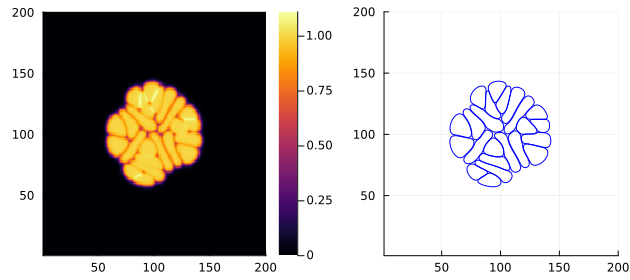

 36.441378 seconds (3.95 M allocations: 64.505 GiB, 3.10% gc time)


In [17]:
dt = 0.01
number_of_iterations = 10000
#plot_phase_field("test_run.png", fields, true)
f_term_result = zeros(size(fields[1].field))
gs_result = zeros(size(fields[1].field))
gint_result = zeros(size(fields[1].field))
phis = [zeros(Int64(simulation_hyperparameters["Nx"]), Int64(simulation_hyperparameters["Ny"])) for _ in 1:size(types,1)]
vector_of_results = [zeros(Int64(simulation_hyperparameters["Nx"]), Int64(simulation_hyperparameters["Ny"])) for _ in 1:size(fields, 1)]
neutrient_field_laplacian = zeros(size(fields[1].field))
h_field_laplacian_result = zeros(size(fields[1].field))



@time for t in 1:number_of_iterations

    for (i, type) in enumerate(types)
        phis[i] = calculate_phi(simulation_hyperparameters, fields, type)
    end
    single_step!(vector_of_results, simulation_hyperparameters, fields, types, phis, f_term_result, gs_result, gint_result, neutrient_field, neutrient_field_laplacian)
    # updating fields and dividing them
    field_size = size(fields, 1)
    for i in 1:field_size
        fields[i].field .+= vector_of_results[i] .* dt
        new_cell = cell_divide!(simulation_hyperparameters, fields[i], volLim, smoothness)
        if new_cell != false
            new_cell = PhaseField(simulation_hyperparameters, fields[i].type, fields[i].type_hyp, new_cell)
            update_phase_field!(simulation_hyperparameters, new_cell)
            push!(fields, new_cell)
            push!(vector_of_results, zeros(size(fields[1].field)))
        end
        update_phase_field!(simulation_hyperparameters, fields[i])
    end
end
plot_phase_field("test_run.png", fields, true)